## Data prep

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pickle
from sklearn.metrics import r2_score, classification_report

pd.set_option('mode.chained_assignment',None)

In [2]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, verbose=False, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 10
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return -r2

In [3]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0, parse_dates = [1]).sort_values(by = 'time')
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation', 'hour_index'], inplace=True)

# Load weather
Weather_Scale = pd.read_csv('data/processed/MinMaxWeather.csv', index_col=0)
weather_var = list(Weather_Scale.index)

# Load slicing
with open("data/processed/Sample_CC", "rb") as fp: 
    cc = pickle.load(fp)

df_full.head()

,time,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
112412,2019-09-01 00:00:18,38,1,0.999999,0.001309,22.4,3.6,2.4,0.0,1010.4,...,0,0,0,0,0,0,0,0,0,0
112413,2019-09-01 00:00:47,38,1,0.999994,0.003418,22.4,3.6,2.4,0.0,1010.4,...,0,0,0,0,0,0,0,0,0,0
112414,2019-09-01 00:01:17,32,1,0.999984,0.005600,22.4,3.6,2.4,0.0,1010.4,...,0,0,0,0,0,0,0,0,0,0
112415,2019-09-01 00:01:23,65,1,0.999982,0.006036,22.4,3.6,2.4,0.0,1010.4,...,0,0,0,0,0,0,0,0,0,0
112416,2019-09-01 00:02:18,38,1,0.999950,0.010035,22.4,3.6,2.4,0.0,1010.4,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# For classification
Clas_Coef = dict(pd.concat([df_full.time.dt.hour.iloc[np.concatenate(cc[:2])],y.iloc[np.concatenate(cc[:2])]], axis = 1).groupby('time')['time_to_reservation'].mean()*2)
df_clas = pd.concat([df_full.time.dt.hour.iloc[cc[2]],y.iloc[cc[2]]], axis = 1)
df_clas['Cut'] = df_clas.time.map(dict(Clas_Coef))
df_clas

,time,time_to_reservation,Cut
114628,19,1.858333,7.422451
114036,16,0.848333,4.623417
114646,19,3.030000,7.422451
112457,0,8.988334,13.413717
112657,4,1.581111,10.862650
...,...,...,...
366,8,0.315278,5.988644
1491,16,0.453611,4.623417
1920,18,0.030833,6.385323
1146,13,0.589167,4.180495


In [5]:
# Common setting
batch_size = 512
num_epochs = 1501

## No Zones

In [6]:
df = df_full.drop(columns = list(df_full.filter(regex = 'lz').columns) + weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1
112412,0.38,1,0.999999,0.001309,0.523730,0,0,1,0
112413,0.38,1,0.999994,0.003418,0.229529,1,0,0,0
112414,0.32,1,0.999984,0.005600,0.043199,0,1,0,0
112415,0.65,1,0.999982,0.006036,0.074036,0,0,1,0
112416,0.38,1,0.999950,0.010035,0.202700,0,0,1,0


In [7]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y.iloc[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y.iloc[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y.iloc[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [8]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(9,32),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 865


Epoch  1: Train Loss 0.018916 , Valid Loss -0.078308 ,Train R2 0.094182, Valid R2 0.088376
Epoch 11: Train Loss -0.096558 , Valid Loss -0.084798 ,Train R2 0.100613, Valid R2 0.093978
Epoch 21: Train Loss -0.098851 , Valid Loss -0.086182 ,Train R2 0.102507, Valid R2 0.095205
Epoch 31: Train Loss -0.100812 , Valid Loss -0.087609 ,Train R2 0.104298, Valid R2 0.096505
Epoch 41: Train Loss -0.102075 , Valid Loss -0.088717 ,Train R2 0.105608, Valid R2 0.097503
Epoch 51: Train Loss -0.103129 , Valid Loss -0.089707 ,Train R2 0.106778, Valid R2 0.098414
Epoch 61: Train Loss -0.104307 , Valid Loss -0.090764 ,Train R2 0.107936, Valid R2 0.099443
Epoch 71: Train Loss -0.106011 , Valid Loss -0.092221 ,Train R2 0.109492, Valid R2 0.100849
Epoch 81: Train Loss -0.109010 , Valid Loss -0.093769 ,Train R2 0.111384, Valid R2 0.102546
Epoch 91: Train Loss -0.111760 , Valid Loss -0.096134 ,Train R2 0.113737, Valid R2 0.105020
Epoch 101: Train Loss -0.113407 , Valid Loss -0.098117 ,Train R2 0.115547, Valid 

Net(
  (seq): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

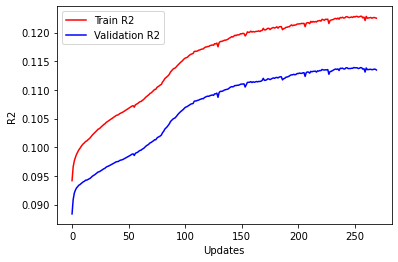

In [9]:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/NoZones.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

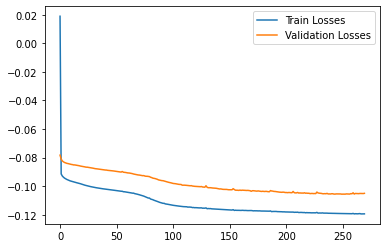

Max Val R2: 0.11390359217639145
Test R2: 0.11567909545053168


In [10]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [11]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.86      0.99      0.92     26725
        Over       0.57      0.05      0.08      4420

    accuracy                           0.86     31145
   macro avg       0.72      0.52      0.50     31145
weighted avg       0.82      0.86      0.80     31145



## Add Zones

In [12]:
df = df_full.drop(columns = weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
112412,0.38,1,0.999999,0.001309,0.523730,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
112413,0.38,1,0.999994,0.003418,0.229529,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112414,0.32,1,0.999984,0.005600,0.043199,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112415,0.65,1,0.999982,0.006036,0.074036,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
112416,0.38,1,0.999950,0.010035,0.202700,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y.iloc[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y.iloc[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y.iloc[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [14]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(265,32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9057


Epoch  1: Train Loss 0.460210 , Valid Loss 0.396622 ,Train R2 -0.381444, Valid R2 -0.384777
Epoch 11: Train Loss -0.124315 , Valid Loss -0.135280 ,Train R2 0.149520, Valid R2 0.141697
Epoch 21: Train Loss -0.165267 , Valid Loss -0.169177 ,Train R2 0.187836, Valid R2 0.175997
Epoch 31: Train Loss -0.182437 , Valid Loss -0.186888 ,Train R2 0.207315, Valid R2 0.193735
Epoch 41: Train Loss -0.195314 , Valid Loss -0.197863 ,Train R2 0.219054, Valid R2 0.204657
Epoch 51: Train Loss -0.203429 , Valid Loss -0.205127 ,Train R2 0.226760, Valid R2 0.211792
Epoch 61: Train Loss -0.207042 , Valid Loss -0.210173 ,Train R2 0.232122, Valid R2 0.216686
Epoch 71: Train Loss -0.213568 , Valid Loss -0.213481 ,Train R2 0.235940, Valid R2 0.219927
Epoch 81: Train Loss -0.215671 , Valid Loss -0.215657 ,Train R2 0.238869, Valid R2 0.222131
Epoch 91: Train Loss -0.219258 , Valid Loss -0.217336 ,Train R2 0.241261, Valid R2 0.223785
Epoch 101: Train Loss -0.220365 , Valid Loss -0.218751 ,Train R2 0.243421, Valid

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

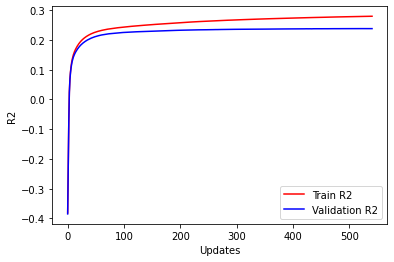

In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithZones.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

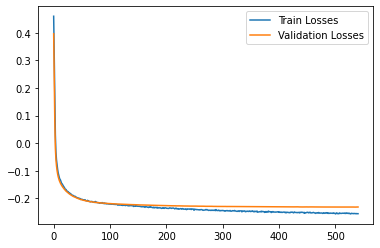

Max Val R2: 0.2382586684604916
Test R2: 0.2364259271345216


In [16]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [17]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.88      0.96      0.92     26725
        Over       0.44      0.20      0.27      4420

    accuracy                           0.85     31145
   macro avg       0.66      0.58      0.59     31145
weighted avg       0.82      0.85      0.83     31145



## Add Encoded zones

In [18]:
df = df_full.drop(columns = weather_var + ['dist_to_station','time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
Mean_Zone_Times = dict(pd.DataFrame({'Zone': df.iloc[np.concatenate(cc[:2])].filter(regex = 'lz').idxmax(axis = 1).values, 'Time':y.iloc[np.concatenate(cc[:2])].values}).groupby('Zone').mean().squeeze())
df['Zone_E'] = df.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
df.drop(columns =  df.filter(regex = 'lz'), inplace = True)
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone_E
112412,0.38,1,0.999999,0.001309,0.523730,0,0,1,0,2.850948
112413,0.38,1,0.999994,0.003418,0.229529,1,0,0,0,3.086176
112414,0.32,1,0.999984,0.005600,0.043199,0,1,0,0,3.897257
112415,0.65,1,0.999982,0.006036,0.074036,0,0,1,0,3.547119
112416,0.38,1,0.999950,0.010035,0.202700,0,0,1,0,1.365234


In [19]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y.iloc[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y.iloc[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y.iloc[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [20]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(10,32),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 897


Epoch  1: Train Loss 0.324685 , Valid Loss 0.203516 ,Train R2 -0.192940, Valid R2 -0.196290
Epoch 11: Train Loss -0.178399 , Valid Loss -0.170585 ,Train R2 0.187782, Valid R2 0.179651
Epoch 21: Train Loss -0.188424 , Valid Loss -0.180149 ,Train R2 0.196968, Valid R2 0.188924
Epoch 31: Train Loss -0.193619 , Valid Loss -0.185517 ,Train R2 0.201915, Valid R2 0.194091
Epoch 41: Train Loss -0.196580 , Valid Loss -0.188722 ,Train R2 0.204801, Valid R2 0.197177
Epoch 51: Train Loss -0.198235 , Valid Loss -0.190716 ,Train R2 0.206476, Valid R2 0.199114
Epoch 61: Train Loss -0.199245 , Valid Loss -0.191970 ,Train R2 0.207508, Valid R2 0.200351
Epoch 71: Train Loss -0.199953 , Valid Loss -0.192839 ,Train R2 0.208246, Valid R2 0.201208
Epoch 81: Train Loss -0.200473 , Valid Loss -0.193476 ,Train R2 0.208795, Valid R2 0.201828
Epoch 91: Train Loss -0.200896 , Valid Loss -0.193986 ,Train R2 0.209245, Valid R2 0.202326
Epoch 101: Train Loss -0.201266 , Valid Loss -0.194449 ,Train R2 0.209631, Valid

Net(
  (seq): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

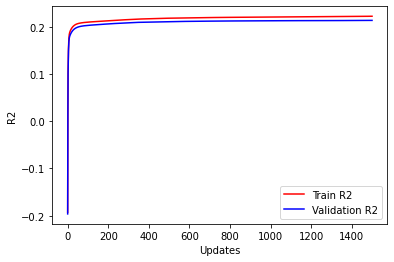

In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0000) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithZonesEncoded.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

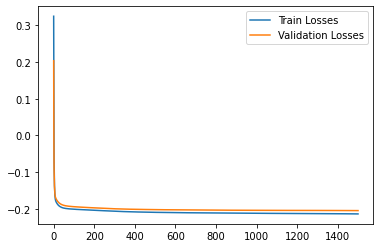

Max Val R2: 0.2133344820429106
Test R2: 0.20883452416085102


In [22]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [23]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.87      0.96      0.92     26725
        Over       0.42      0.16      0.23      4420

    accuracy                           0.85     31145
   macro avg       0.65      0.56      0.57     31145
weighted avg       0.81      0.85      0.82     31145



## Add Weather + Dist to station

In [24]:
df = df_full.drop(columns = list(df_full.filter(regex = 'lz').columns) + ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,degree,eng_118I,eng_COOPER,eng_I3,eng_X1
112412,0.38,1,0.999999,0.001309,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,0.87,0.060328,0.523730,0,0,1,0
112413,0.38,1,0.999994,0.003418,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,0.87,0.273313,0.229529,1,0,0,0
112414,0.32,1,0.999984,0.005600,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,0.87,0.106948,0.043199,0,1,0,0
112415,0.65,1,0.999982,0.006036,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,0.87,0.088363,0.074036,0,0,1,0
112416,0.38,1,0.999950,0.010035,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,0.87,0.079369,0.202700,0,0,1,0


In [25]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y.iloc[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y.iloc[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y.iloc[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [26]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(17,128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 10625


Epoch  1: Train Loss 0.120402 , Valid Loss -0.055026 ,Train R2 0.068203, Valid R2 0.064926
Epoch 11: Train Loss -0.101151 , Valid Loss -0.111562 ,Train R2 0.124947, Valid R2 0.117964
Epoch 21: Train Loss -0.106906 , Valid Loss -0.115637 ,Train R2 0.128643, Valid R2 0.121609
Epoch 31: Train Loss -0.109269 , Valid Loss -0.117105 ,Train R2 0.130250, Valid R2 0.122914
Epoch 41: Train Loss -0.113286 , Valid Loss -0.117967 ,Train R2 0.131302, Valid R2 0.123856
Epoch 51: Train Loss -0.114452 , Valid Loss -0.119287 ,Train R2 0.132567, Valid R2 0.124869
EarlyStopping counter: 5 out of 20
Epoch 61: Train Loss -0.116112 , Valid Loss -0.120109 ,Train R2 0.133565, Valid R2 0.125675
Epoch 71: Train Loss -0.116261 , Valid Loss -0.120326 ,Train R2 0.134125, Valid R2 0.126129
Epoch 81: Train Loss -0.117814 , Valid Loss -0.121551 ,Train R2 0.135309, Valid R2 0.127151
EarlyStopping counter: 5 out of 20
Epoch 91: Train Loss -0.119810 , Valid Loss -0.122148 ,Train R2 0.136328, Valid R2 0.127856
Epoch 101: 

Net(
  (seq): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

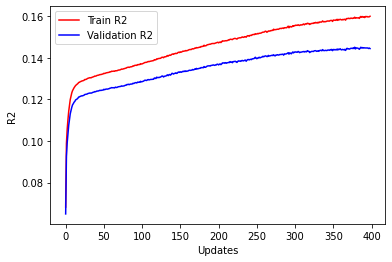

In [27]:
optimizer = optim.Adam(net.parameters(), lr=0.0003, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/WithWeather.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

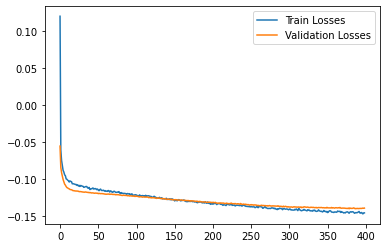

Max Val R2: 0.14510278465818638
Test R2: 0.14335268658782585


In [28]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [29]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.86      0.99      0.92     26725
        Over       0.45      0.04      0.08      4420

    accuracy                           0.86     31145
   macro avg       0.66      0.52      0.50     31145
weighted avg       0.80      0.86      0.80     31145



## With all

In [30]:
df = df_full.drop(columns = ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
112412,0.38,1,0.999999,0.001309,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,...,0,0,0,0,0,0,0,0,0,0
112413,0.38,1,0.999994,0.003418,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,...,0,0,0,0,0,0,0,0,0,0
112414,0.32,1,0.999984,0.005600,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,...,0,0,0,0,0,0,0,0,0,0
112415,0.65,1,0.999982,0.006036,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,...,0,0,0,0,0,0,0,0,0,0
112416,0.38,1,0.999950,0.010035,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,...,0,0,0,0,0,0,0,0,0,0


In [31]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y.iloc[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y.iloc[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y.iloc[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [32]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(273,32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=273, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 9313


Epoch  1: Train Loss 0.480677 , Valid Loss 0.415721 ,Train R2 -0.401370, Valid R2 -0.404202
Epoch 11: Train Loss -0.136384 , Valid Loss -0.146601 ,Train R2 0.161888, Valid R2 0.153312
Epoch 21: Train Loss -0.169758 , Valid Loss -0.177323 ,Train R2 0.195413, Valid R2 0.184334
Epoch 31: Train Loss -0.186340 , Valid Loss -0.192364 ,Train R2 0.211457, Valid R2 0.199193
Epoch 41: Train Loss -0.198096 , Valid Loss -0.202964 ,Train R2 0.222508, Valid R2 0.209474
Epoch 51: Train Loss -0.205885 , Valid Loss -0.210225 ,Train R2 0.230339, Valid R2 0.216465
Epoch 61: Train Loss -0.213392 , Valid Loss -0.215097 ,Train R2 0.236081, Valid R2 0.221197
Epoch 71: Train Loss -0.217310 , Valid Loss -0.218283 ,Train R2 0.240268, Valid R2 0.224370
Epoch 81: Train Loss -0.219006 , Valid Loss -0.220783 ,Train R2 0.243739, Valid R2 0.226659
Epoch 91: Train Loss -0.222087 , Valid Loss -0.222354 ,Train R2 0.246666, Valid R2 0.228256
Epoch 101: Train Loss -0.225992 , Valid Loss -0.223739 ,Train R2 0.249357, Valid

Net(
  (seq): Sequential(
    (0): Linear(in_features=273, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

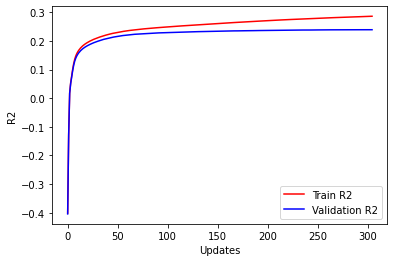

In [33]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/Full.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

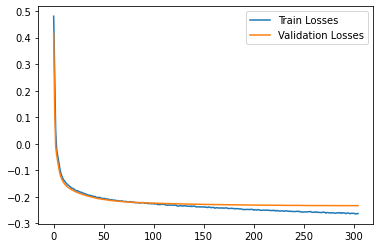

Max Val R2: 0.23954718382442308
Test R2: 0.2371734035898152


In [34]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [35]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.88      0.96      0.92     26725
        Over       0.44      0.20      0.28      4420

    accuracy                           0.85     31145
   macro avg       0.66      0.58      0.60     31145
weighted avg       0.82      0.85      0.83     31145



## With all and encoded zones

In [36]:
df = df_full.drop(columns = ['time'])
df['leave_fuel'] = df['leave_fuel']/100
df['degree'] = df['degree']/50
df['dist_to_station'] = df['dist_to_station']/5000
df[Weather_Scale.index] = (df[Weather_Scale.index] - Weather_Scale['Min'])/Weather_Scale['diff']
Mean_Zone_Times = dict(pd.DataFrame({'Zone': df.iloc[np.concatenate(cc[:2])].filter(regex = 'lz').idxmax(axis = 1).values, 'Time':y.iloc[np.concatenate(cc[:2])].values}).groupby('Zone').mean().squeeze())
df['Zone_E'] = df.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
df.drop(columns =  df.filter(regex = 'lz'), inplace = True)
df.head()

,leave_fuel,weekend,Time_Cos,Time_Sin,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,degree,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone_E
112412,0.38,1,0.999999,0.001309,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,0.87,0.060328,0.523730,0,0,1,0,2.850948
112413,0.38,1,0.999994,0.003418,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,0.87,0.273313,0.229529,1,0,0,0,3.086176
112414,0.32,1,0.999984,0.005600,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,0.87,0.106948,0.043199,0,1,0,0,3.897257
112415,0.65,1,0.999982,0.006036,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,0.87,0.088363,0.074036,0,0,1,0,3.547119
112416,0.38,1,0.999950,0.010035,0.945205,0.330275,0.705882,0.0,0.432184,0.664348,0.87,0.079369,0.202700,0,0,1,0,1.365234


In [37]:
X_train = torch.tensor(df.iloc[cc[0]].to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y.iloc[cc[0]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(df.iloc[cc[1]].to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y.iloc[cc[1]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(df.iloc[cc[2]].to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y.iloc[cc[2]].to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [38]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(18,32),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x

net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 1153


Epoch  1: Train Loss 0.305874 , Valid Loss 0.181839 ,Train R2 -0.174789, Valid R2 -0.176637
Epoch 11: Train Loss -0.174688 , Valid Loss -0.166069 ,Train R2 0.183765, Valid R2 0.175171
Epoch 21: Train Loss -0.183185 , Valid Loss -0.174619 ,Train R2 0.191821, Valid R2 0.183498
Epoch 31: Train Loss -0.188883 , Valid Loss -0.180880 ,Train R2 0.197299, Valid R2 0.189457
Epoch 41: Train Loss -0.192846 , Valid Loss -0.185323 ,Train R2 0.201157, Valid R2 0.193631
Epoch 51: Train Loss -0.195448 , Valid Loss -0.188304 ,Train R2 0.203735, Valid R2 0.196429
Epoch 61: Train Loss -0.197210 , Valid Loss -0.190354 ,Train R2 0.205493, Valid R2 0.198362
Epoch 71: Train Loss -0.198450 , Valid Loss -0.191818 ,Train R2 0.206753, Valid R2 0.199718
Epoch 81: Train Loss -0.199382 , Valid Loss -0.192902 ,Train R2 0.207710, Valid R2 0.200710
Epoch 91: Train Loss -0.200233 , Valid Loss -0.193855 ,Train R2 0.208562, Valid R2 0.201577
Epoch 101: Train Loss -0.201023 , Valid Loss -0.194729 ,Train R2 0.209344, Valid

Net(
  (seq): Sequential(
    (0): Linear(in_features=18, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

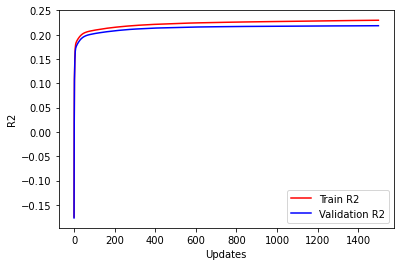

In [39]:
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

path = 'Results/SimpleNN/FullEncoded.pt'
early_stopping = EarlyStopping(patience=20, verbose=False, path = path)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = r2_loss(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train += batch_loss
    train_losses.append(cur_loss_train/num_batches_train)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())


    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val += r2_loss(output, y_val[slce])

    val_losses.append(cur_loss_val/num_batches_valid)

    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train R2','Validation R2'])
plt.xlabel('Updates'), plt.ylabel('R2')

# Load best model
net.load_state_dict(torch.load(path))
net.eval()

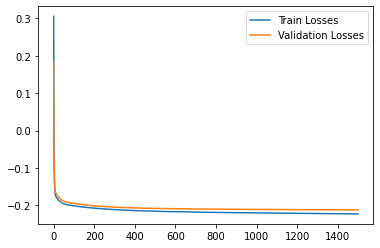

Max Val R2: 0.21866882112769126
Test R2: 0.21224508579749113


In [40]:
plt.plot(epoch, [x.detach().numpy() for x in train_losses], [x.detach().numpy() for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

In [41]:
df_clas['Preds'] = net.forward(X_test).detach().numpy()[:,0]
print(classification_report(df_clas.time_to_reservation > df_clas.Cut, df_clas.Preds > df_clas.Cut, target_names = ['Under','Over']))

              precision    recall  f1-score   support

       Under       0.87      0.97      0.92     26725
        Over       0.42      0.15      0.22      4420

    accuracy                           0.85     31145
   macro avg       0.65      0.56      0.57     31145
weighted avg       0.81      0.85      0.82     31145

